In [1]:
import sys
sys.path.append("..")
import models
import policy_gradient_methods
import utils
import gymnasium as gym
import torch
import random

# Settings

In [2]:
ENVIRONMENT_ID = "CartPole-v1"
NUM_RUNS_PER_METHOD = 9
NUM_EPISODES_PER_RUN = 1000
GRAD_CLIP_VALUE = 10
GAMMA = 0.99
NN_HIDDEN_LAYER_SIZES = [8, 4]
RNG_SEED = 7
device = torch.device("cpu")
print("PyTorch device:", device)
torch.manual_seed(RNG_SEED)
random.seed(RNG_SEED)

PyTorch device: cpu


# REINFORCE

## Linear model

Started run 1/9
Started run 2/9
Started run 3/9
Started run 4/9
Started run 5/9
Started run 6/9
Started run 7/9
Started run 8/9
Started run 9/9


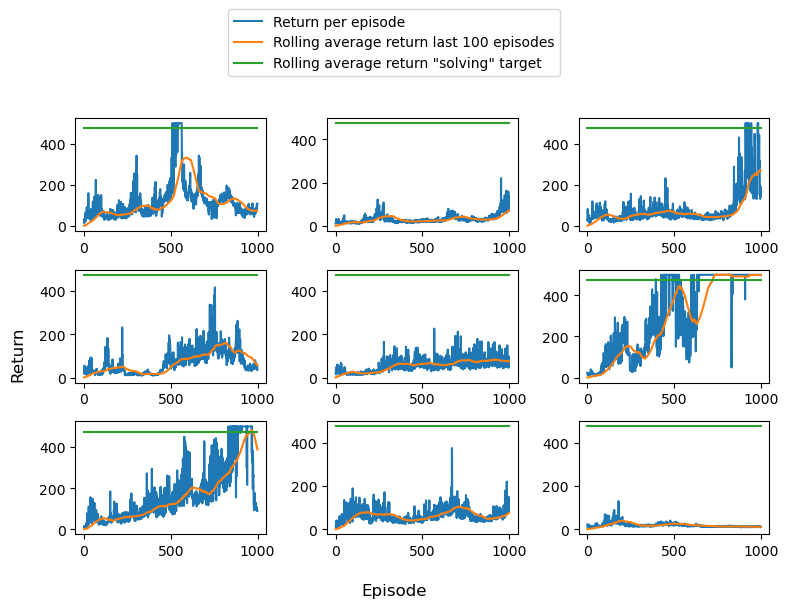

In [3]:
returns_per_run = []
env = gym.make(ENVIRONMENT_ID)
for run in range(NUM_RUNS_PER_METHOD):
    print(f"Started run {run + 1}/{NUM_RUNS_PER_METHOD}")
    policy_model = torch.nn.Sequential(
        torch.nn.Linear(env.observation_space.shape[0], env.action_space.n),
        torch.nn.Softmax(dim=1)
    ).to(device)
    policy_optimizer = torch.optim.SGD(policy_model.parameters(), lr=0.01)
    returns = policy_gradient_methods.train_episodic_reinforce(
        env, policy_model, policy_optimizer, device, RNG_SEED, NUM_EPISODES_PER_RUN, GAMMA, GRAD_CLIP_VALUE
    )
    returns_per_run.append(returns)
env.close()
utils.plot_returns_multiple_runs(returns_per_run, env.spec.reward_threshold)

## Neural network models

Started run 1/9
Started run 2/9
Started run 3/9
Started run 4/9
Started run 5/9
Started run 6/9
Started run 7/9
Started run 8/9
Started run 9/9


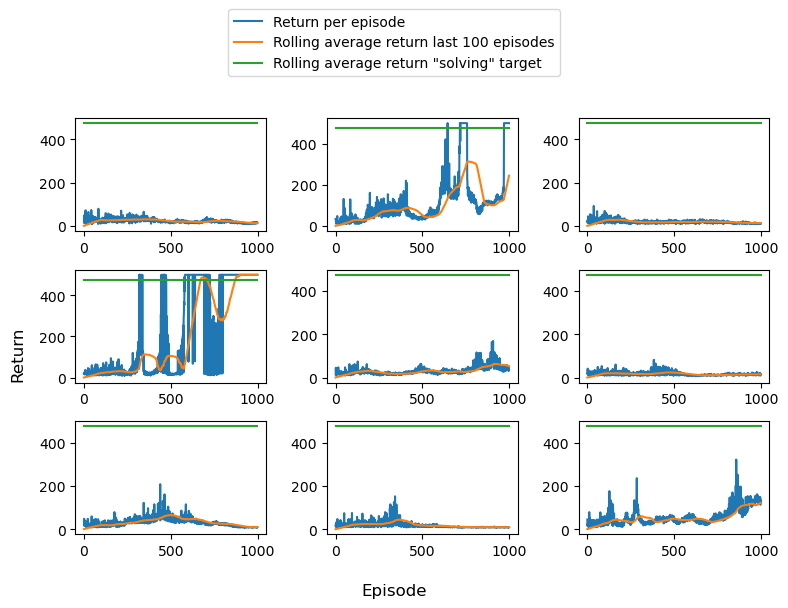

In [4]:
returns_per_run = []
env = gym.make(ENVIRONMENT_ID)
for run in range(NUM_RUNS_PER_METHOD):
    print(f"Started run {run + 1}/{NUM_RUNS_PER_METHOD}")
    policy_model = models.create_simple_nn(
        env.observation_space.shape[0],
        env.action_space.n,
        NN_HIDDEN_LAYER_SIZES,
        output_activation="softmax"
    ).to(device)
    policy_optimizer = torch.optim.AdamW(policy_model.parameters(), lr=0.01)
    returns = policy_gradient_methods.train_episodic_reinforce(
        env, policy_model, policy_optimizer, device, RNG_SEED, NUM_EPISODES_PER_RUN, GAMMA, GRAD_CLIP_VALUE
    )
    returns_per_run.append(returns)
env.close()
utils.plot_returns_multiple_runs(returns_per_run, env.spec.reward_threshold)

# REINFORCE with baseline

## Linear models

Started run 1/9
Started run 2/9
Started run 3/9
Started run 4/9
Started run 5/9
Started run 6/9
Started run 7/9
Started run 8/9
Started run 9/9


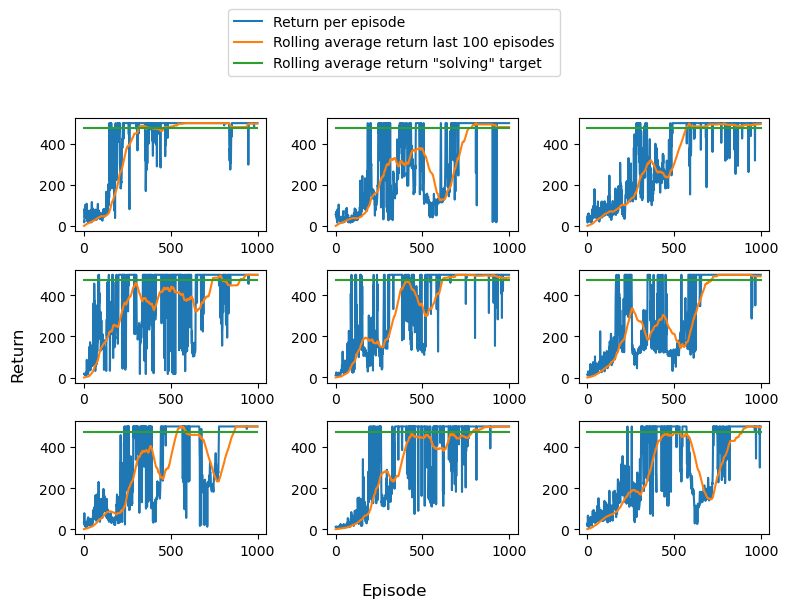

In [5]:
returns_per_run = []
env = gym.make(ENVIRONMENT_ID)
for run in range(NUM_RUNS_PER_METHOD):
    print(f"Started run {run + 1}/{NUM_RUNS_PER_METHOD}")
    policy_model = torch.nn.Sequential(
        torch.nn.Linear(env.observation_space.shape[0], env.action_space.n),
        torch.nn.Softmax(dim=1)
    ).to(device)
    value_model = torch.nn.Linear(env.observation_space.shape[0], 1).to(device)
    policy_optimizer = torch.optim.SGD(policy_model.parameters(), lr=0.01)
    value_optimizer = torch.optim.SGD(value_model.parameters(), lr=0.01)
    returns = policy_gradient_methods.train_episodic_reinforce_with_baseline(
        env, policy_model, value_model, policy_optimizer, value_optimizer, device,
        RNG_SEED, NUM_EPISODES_PER_RUN, GAMMA, GRAD_CLIP_VALUE
    )
    returns_per_run.append(returns)
env.close()
utils.plot_returns_multiple_runs(returns_per_run, env.spec.reward_threshold)

## Neural network models

Started run 1/9
Started run 2/9
Started run 3/9
Started run 4/9
Started run 5/9
Started run 6/9
Started run 7/9
Started run 8/9
Started run 9/9


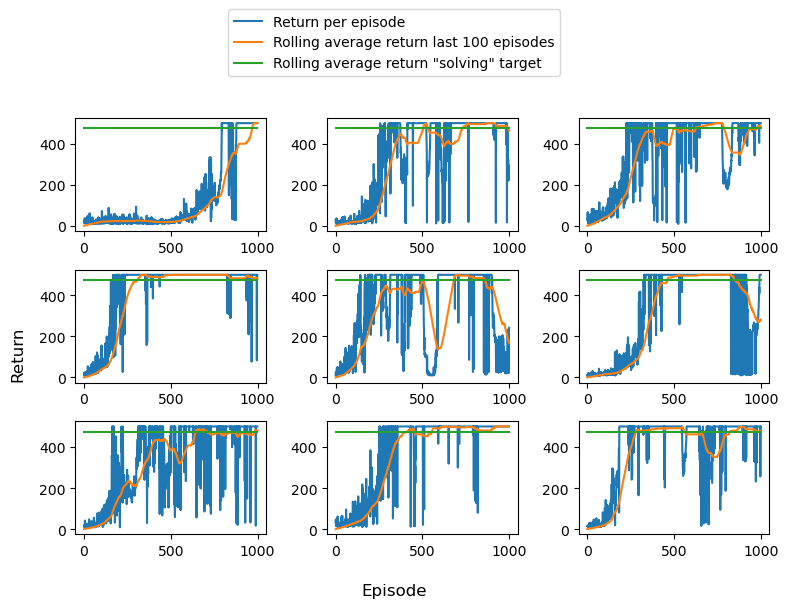

In [6]:
returns_per_run = []
env = gym.make(ENVIRONMENT_ID)
for run in range(NUM_RUNS_PER_METHOD):
    print(f"Started run {run + 1}/{NUM_RUNS_PER_METHOD}")
    policy_model = models.create_simple_nn(
        env.observation_space.shape[0],
        env.action_space.n,
        NN_HIDDEN_LAYER_SIZES,
        output_activation="softmax"
    ).to(device)
    value_model = models.create_simple_nn(env.observation_space.shape[0], 1, NN_HIDDEN_LAYER_SIZES).to(device)
    policy_optimizer = torch.optim.AdamW(policy_model.parameters(), lr=0.01)
    value_optimizer = torch.optim.AdamW(value_model.parameters(), lr=0.01)
    returns = policy_gradient_methods.train_episodic_reinforce_with_baseline(
        env, policy_model, value_model, policy_optimizer, value_optimizer, device,
        RNG_SEED, NUM_EPISODES_PER_RUN, GAMMA, GRAD_CLIP_VALUE
    )
    returns_per_run.append(returns)
env.close()
utils.plot_returns_multiple_runs(returns_per_run, env.spec.reward_threshold)